In [1]:
import healpy as h
import sys, os
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../modules/'))
sys.path.append(os.path.abspath('/Users/adityarotti/Documents/Work/core_codes/generate_apodized_mask/'))
from modules.settings import global_mmf_settings as gset
from modules.data_preprocess import preprocess_planck_data as ppd
from modules.masking import gen_masks
from modules.master import binned_master as bm
from astropy.io import fits
from copy import copy,deepcopy
import pymain as gen_apo_mask
%pylab notebook

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

import collections
result_path="../../results/yy_spec/" ; ensure_dir(result_path)
datapath="/Users/adityarotti/Documents/Work/Data/Planck/"
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
dataset="planck_pr3"
whichch="hfi"
mask_point_sources=False
numprocs=35

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.

use_psf_data=True
ps_suffix="_inpainted_data"
if mask_point_sources:
    use_psf_data=False
    ps_suffix="_masked_data"

figstamp=dataset + "_" + whichch + ps_suffix
dir_suffix=whichch + ps_suffix

save_results=False
run_analysis=False

figstamp,dir_suffix

outpath="/results/" + dataset + "/planck_cosmo_cat_" + dir_suffix + "/"
tempdatapath="/tempdata/" + dataset + "/planck_cosmo_cat/"
gset.setup_mmf_config(dataset=dataset,outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=10.,do_band_pass=True,use_psf_data=use_psf_data)

In [3]:
do_dgrade=True ; nsideout=2048
lmax=1500
masklmax=2*nsideout
snr_cutoff=6.
apowidth=30. # arcminutes
lf_ps_mask=False

dirname="snr"+str(int(snr_cutoff)) + "_lmax" + str(int(lmax)) + "_mlmax" + str(int(masklmax)) 
dirname=dirname + "_apow" + str(int(apowidth))
if lf_ps_mask:
    dirname=dirname + "_lfpsT"
else:
    dirname=dirname + "_lfpsF"
print dirname

figpath=result_path + "/" + dirname + "/figs/"  ; ensure_dir(figpath)
dataout_path=result_path + "/" + dirname + "/data/"   ; ensure_dir(dataout_path)

snr6_lmax1500_mlmax4096_apow30_lfpsF


In [4]:
mmf3=ppd.get_mmf3_catalogue(zknown=False,snrthr=6.,cosmo_flag=True)
mmf3=ppd.eval_M500_T500_theta500(mmf3)
median_theta500=median(mmf3["theta500"][mmf3["REDSHIFT"]>0])
mmf3["theta500"][[mmf3["REDSHIFT"]<0]]=median_theta500
shape(mmf3["REDSHIFT"])

/Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detection/Planck_MMF/analysis/modules/cosmology/cosmo_fn.py:26: RuntimeWarning: divide by zero encountered in divide
  return d0(z)/(1.+z)
/Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detection/Planck_MMF/analysis/modules/cosmology/cosmo_fn.py:62: RuntimeWarning: invalid value encountered in multiply
  y=rhs*(500./dA(z))


(439,)

<IPython.core.display.Javascript object>


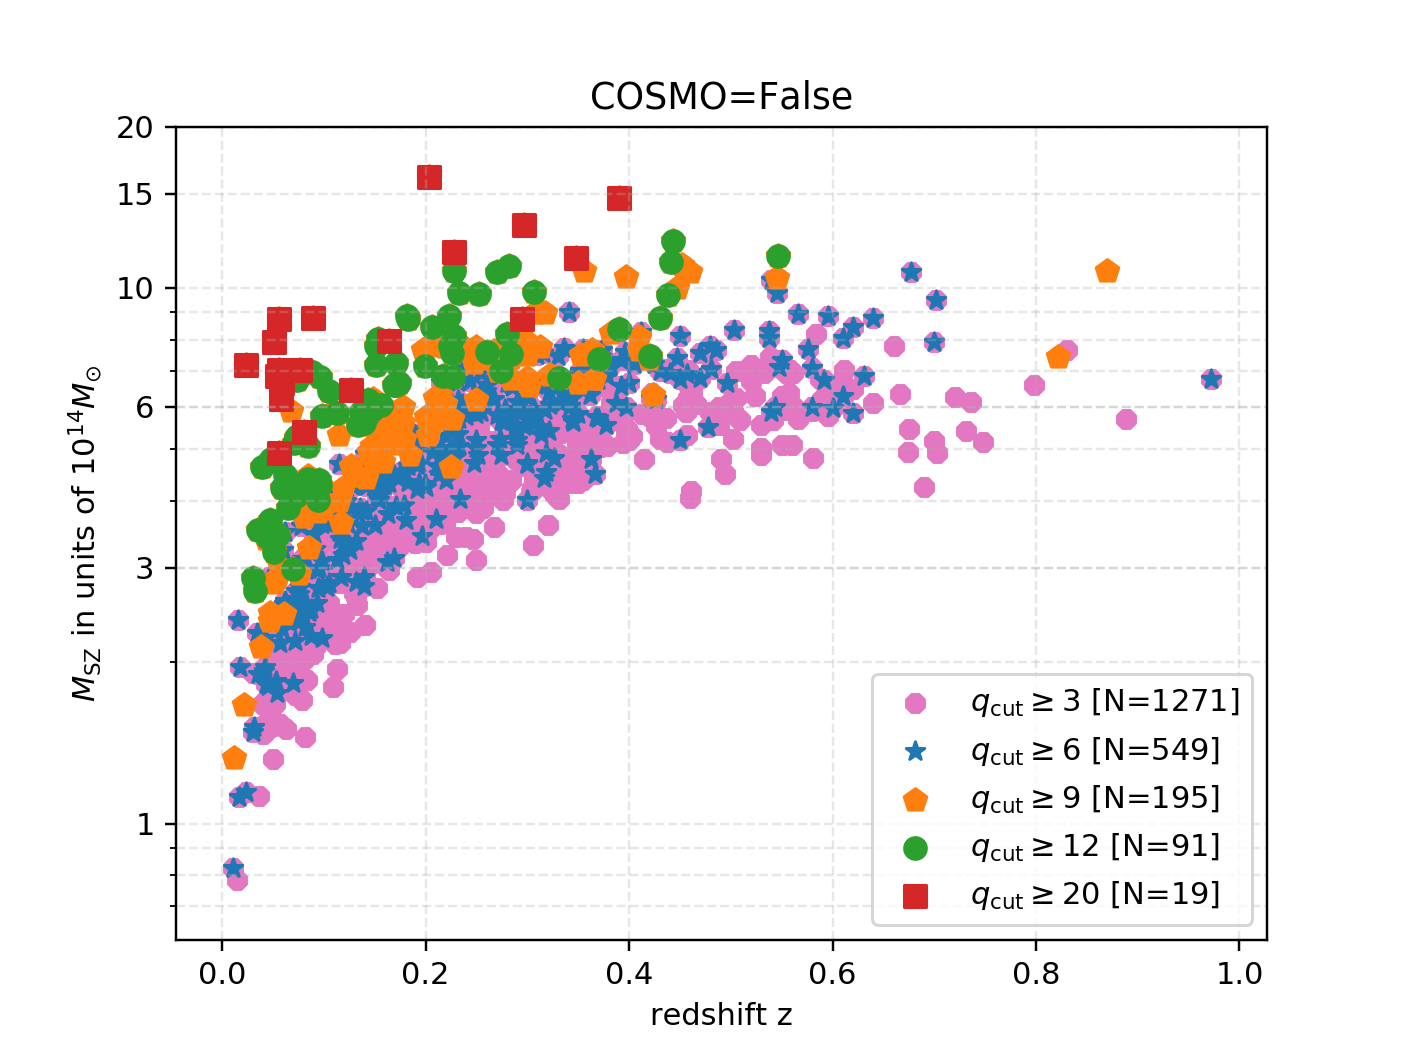

In [9]:
mmf3={}

for qcut in [3,6,9,12,20]:
    if qcut==0:
        mmf3[qcut]=ppd.get_mmf3_catalogue(zknown=False,snrthr=qcut,cosmo_flag=False)
    else:
        mmf3[qcut]=ppd.get_mmf3_catalogue(zknown=False,snrthr=qcut,cosmo_flag=False)
    
mt={} ; mt[3]="8" ; mt[6]="*" ; mt[9]="p" ; mt[12]="o" ; mt[20]="s"
ms={} ; ms[3]=40 ; ms[6]=40 ; ms[9]=60 ; ms[12]=50 ; ms[20]=50
mc={} ; mc[3]="tab:pink" ; mc[6]="tab:blue" ; mc[9]="tab:orange" ; mc[12]="tab:green" ; mc[20]="tab:red"
figure()
# qcut=0
# scatter(mmf3[qcut]["REDSHIFT"][mmf3[qcut]["REDSHIFT"]>=0],mmf3[qcut]["MSZ"][mmf3[qcut]["REDSHIFT"]>=0],marker="o",s=40,
#             label=r"$q_{\rm cut} \geq$" + str(qcut) + " [N=" + str(len(mmf3[qcut]["REDSHIFT"])) +"]",color="gray")
for qcut in [3,6,9,12,20]:
    scatter(mmf3[qcut]["REDSHIFT"][mmf3[qcut]["REDSHIFT"]>=0],mmf3[qcut]["MSZ"][mmf3[qcut]["REDSHIFT"]>=0],marker=mt[qcut],s=ms[qcut],
            label=r"$q_{\rm cut} \geq$" + str(qcut) + " [N=" + str(len(mmf3[qcut]["REDSHIFT"])) +"]",color=mc[qcut])
semilogy()
title("COSMO=False")
xlabel("redshift z")
ylabel(r"$M_{\rm SZ}$ in units of" + " $10^{14} M_{\odot}$")
yticks([1,3,6,10,15,20],[1,3,6,10,15,20])
legend(loc=0)
grid(which="both",linestyle="dashed",alpha=0.3)
figname="../../results/yy_spec/sz_m_z_qcut_cosmo_false.pdf"
savefig(figname, bbox_inches="tight",dpi=200)
figname="../../results/yy_spec/sz_m_z_qcut_cosmo_false.jpeg"
savefig(figname, bbox_inches="tight",dpi=200)

In [6]:
tot=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_psmask/data/total_yy_spec.txt")
tot_g40=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal40_psmask/data/total_yy_spec.txt")
tot_g30=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal30_psmask/data/total_yy_spec.txt")
tot_g60=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal60_psmask/data/total_yy_spec.txt")

urc3=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")
urc3_g40=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal40_psmask/data/unresolved_yy_spec.txt")
urc3_g30=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal30_psmask/data/unresolved_yy_spec.txt")
urc3_g60=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal60_psmask/data/unresolved_yy_spec.txt")
urc6=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")
urc9=loadtxt("../../results/yy_spec/snr9_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")
urc12=loadtxt("../../results/yy_spec/snr12_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")
urc20=loadtxt("../../results/yy_spec/snr20_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")
urc20_g40=loadtxt("../../results/yy_spec/snr20_lmax1500_mlmax4096_apow15_gal40_psmask/data/unresolved_yy_spec.txt")
urc20_g60=loadtxt("../../results/yy_spec/snr20_lmax1500_mlmax4096_apow15_gal60_psmask/data/unresolved_yy_spec.txt")

rc3=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_psmask/data/resolved_yy_spec.txt")
rc3_g40=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal40_psmask/data/resolved_yy_spec.txt")
rc3_g30=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal30_psmask/data/resolved_yy_spec.txt")
rc3_g60=loadtxt("../../results/yy_spec/snr3_lmax1500_mlmax4096_apow15_gal60_psmask/data/resolved_yy_spec.txt")
rc6=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/resolved_yy_spec.txt")
rc9=loadtxt("../../results/yy_spec/snr9_lmax1500_mlmax4096_apow15_psmask/data/resolved_yy_spec.txt")
rc12=loadtxt("../../results/yy_spec/snr12_lmax1500_mlmax4096_apow15_psmask/data/resolved_yy_spec.txt")
rc20=loadtxt("../../results/yy_spec/snr20_lmax1500_mlmax4096_apow15_psmask/data/resolved_yy_spec.txt")
rc20_g40=loadtxt("../../results/yy_spec/snr20_lmax1500_mlmax4096_apow15_gal40_psmask/data/resolved_yy_spec.txt")
rc20_g30=loadtxt("../../results/yy_spec/snr20_lmax1500_mlmax4096_apow15_gal30_psmask/data/resolved_yy_spec.txt")
rc20_g60=loadtxt("../../results/yy_spec/snr20_lmax1500_mlmax4096_apow15_gal60_psmask/data/resolved_yy_spec.txt")

data=loadtxt("../../tempdata/diffuse-rotti++20_step_3_bf_szpowerspectrum.txt")

planck_yy=np.loadtxt(datapath + "/maps/bolliet2018.txt")

<IPython.core.display.Javascript object>


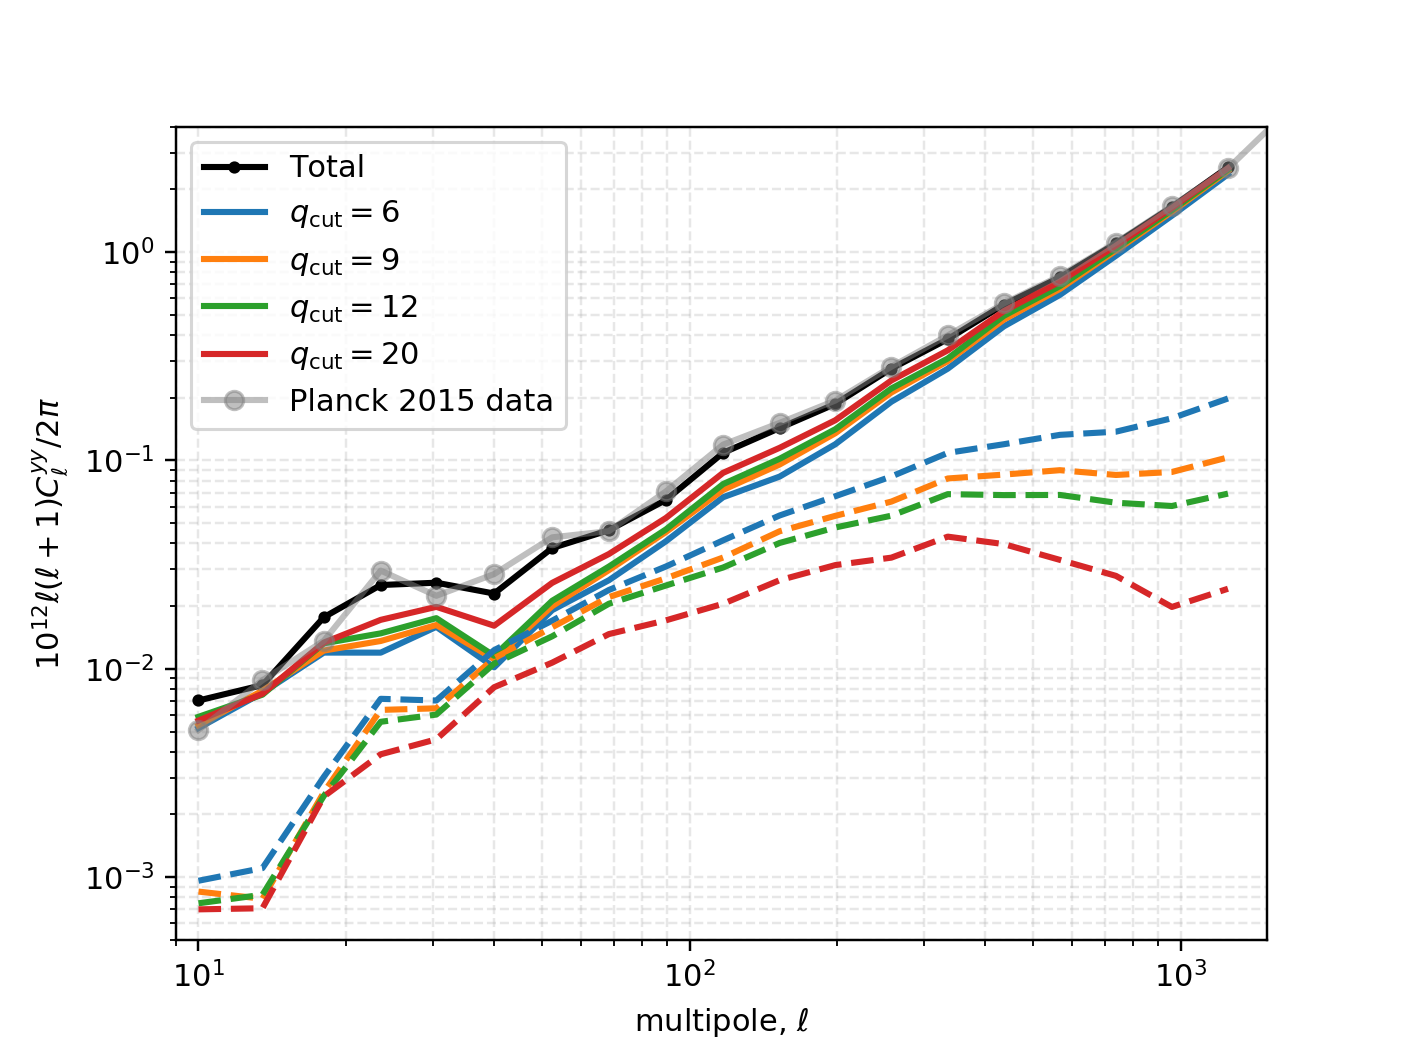

In [36]:
## figure()
plot(tot[:,2],tot[:,3],"k.-",lw=2,label="Total")
plot(urc6[:,2],urc6[:,3],lw=2,c="tab:blue",label=r"$q_{\rm cut}=6$")
plot(urc9[:,2],urc9[:,3],lw=2,c="tab:orange",label=r"$q_{\rm cut}=9$")
plot(urc12[:,2],urc12[:,3],lw=2,c="tab:green",label=r"$q_{\rm cut}=12$")
plot(urc20[:,2],urc20[:,3],lw=2,c="tab:red",label=r"$q_{\rm cut}=20$")
# loglog()
# legend(loc=0)
# grid(which="both",alpha=0.3,linestyle="dashed")

# figure()
plot(rc6[:,2],rc6[:,3],"--",lw=2,c="tab:blue",label="")
plot(rc9[:,2],rc9[:,3],"--",lw=2,c="tab:orange",label="")
plot(rc12[:,2],rc12[:,3],"--",lw=2,c="tab:green",label="")
plot(rc20[:,2],rc20[:,3],"--",lw=2,c="tab:red",label="")
plot(planck_yy[:,0],planck_yy[:,1],"-o",color="gray",lw=2,label="Planck 2015 data",alpha=0.5)
loglog()
legend(loc=0)
grid(which="both",alpha=0.3,linestyle="dashed")
xlim(9,1500)
ylim(5e-4,4)
xlabel("multipole, $\ell$")
ylabel(r"$10^{12} \ell(\ell+1) C_{\ell}^{yy}/2 \pi$")
figname="../../results/yy_spec/all_qcut_yy_spec.pdf"
savefig(figname, bbox_inches="tight",dpi=200)

<IPython.core.display.Javascript object>


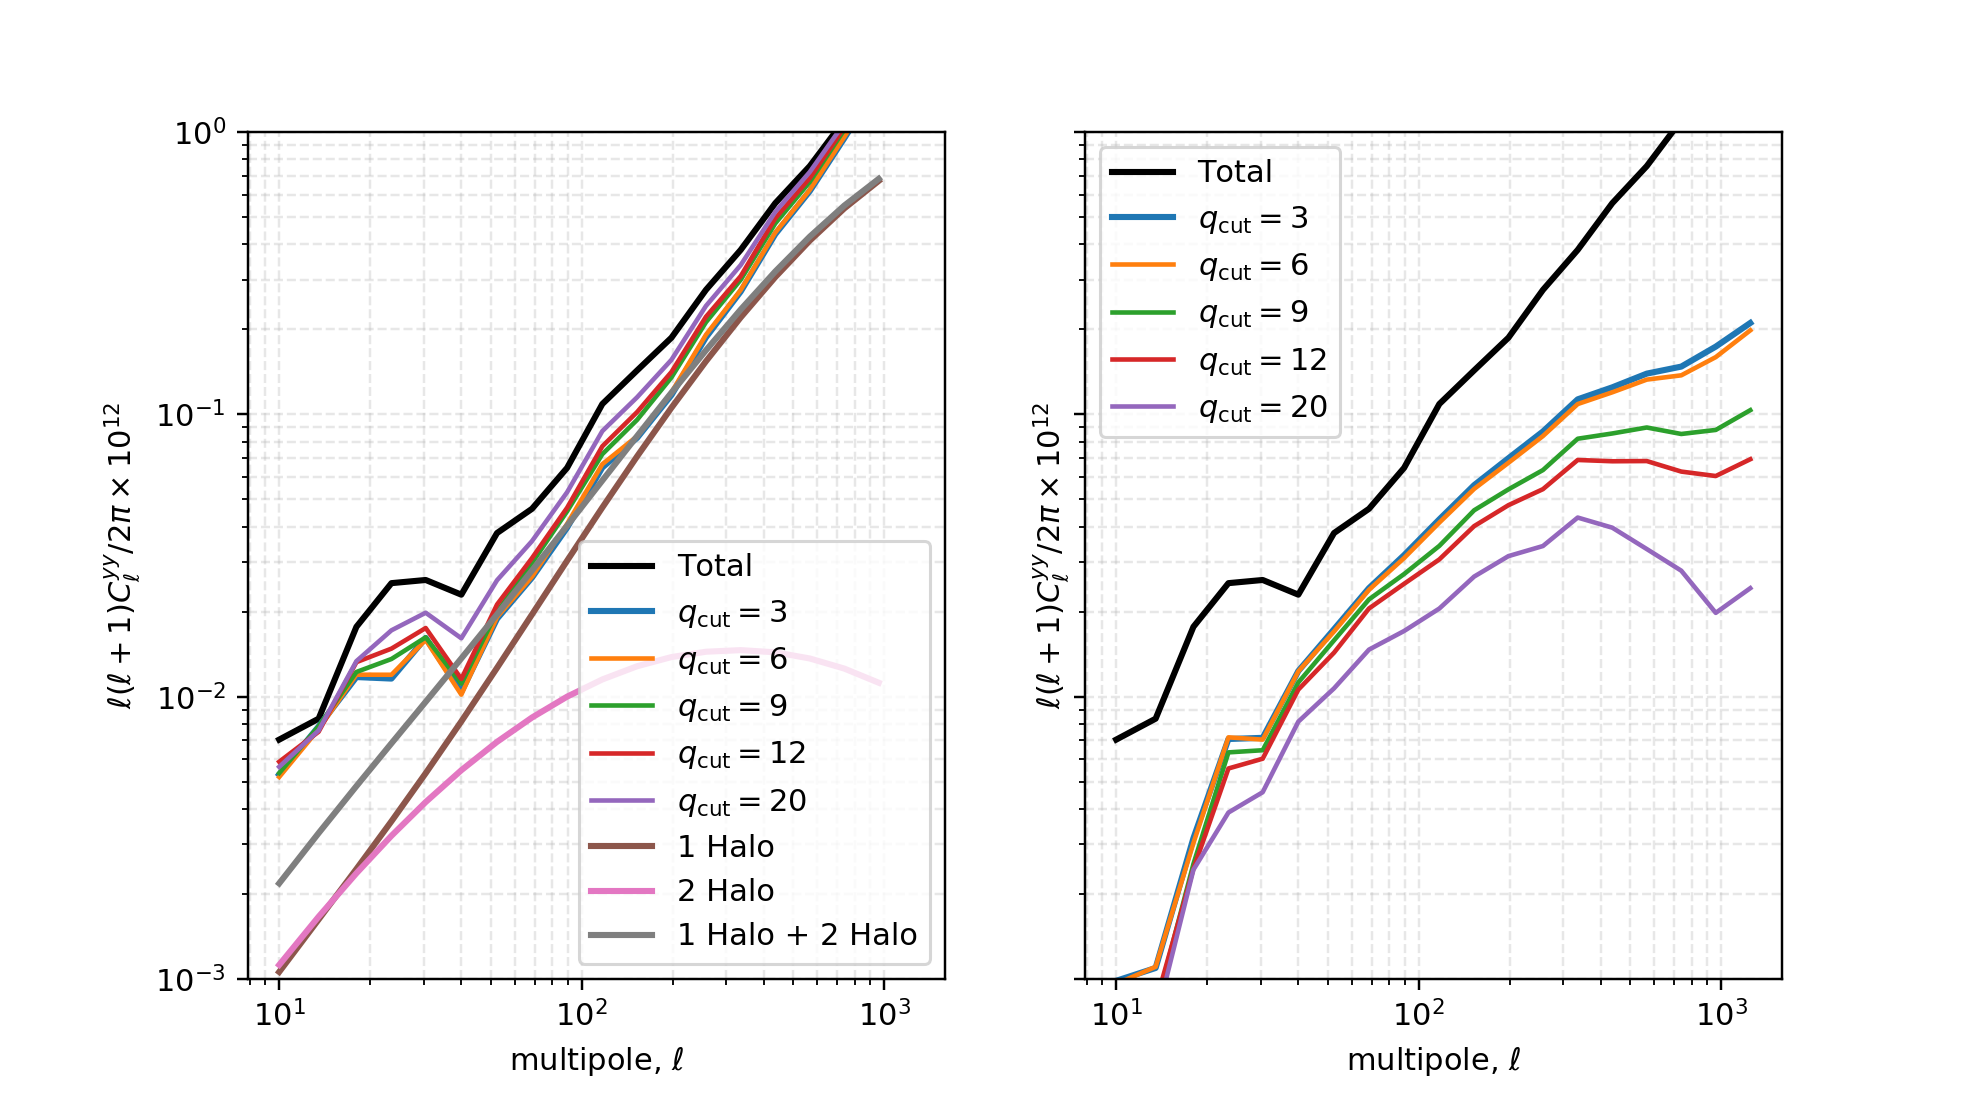

<IPython.core.display.Javascript object>


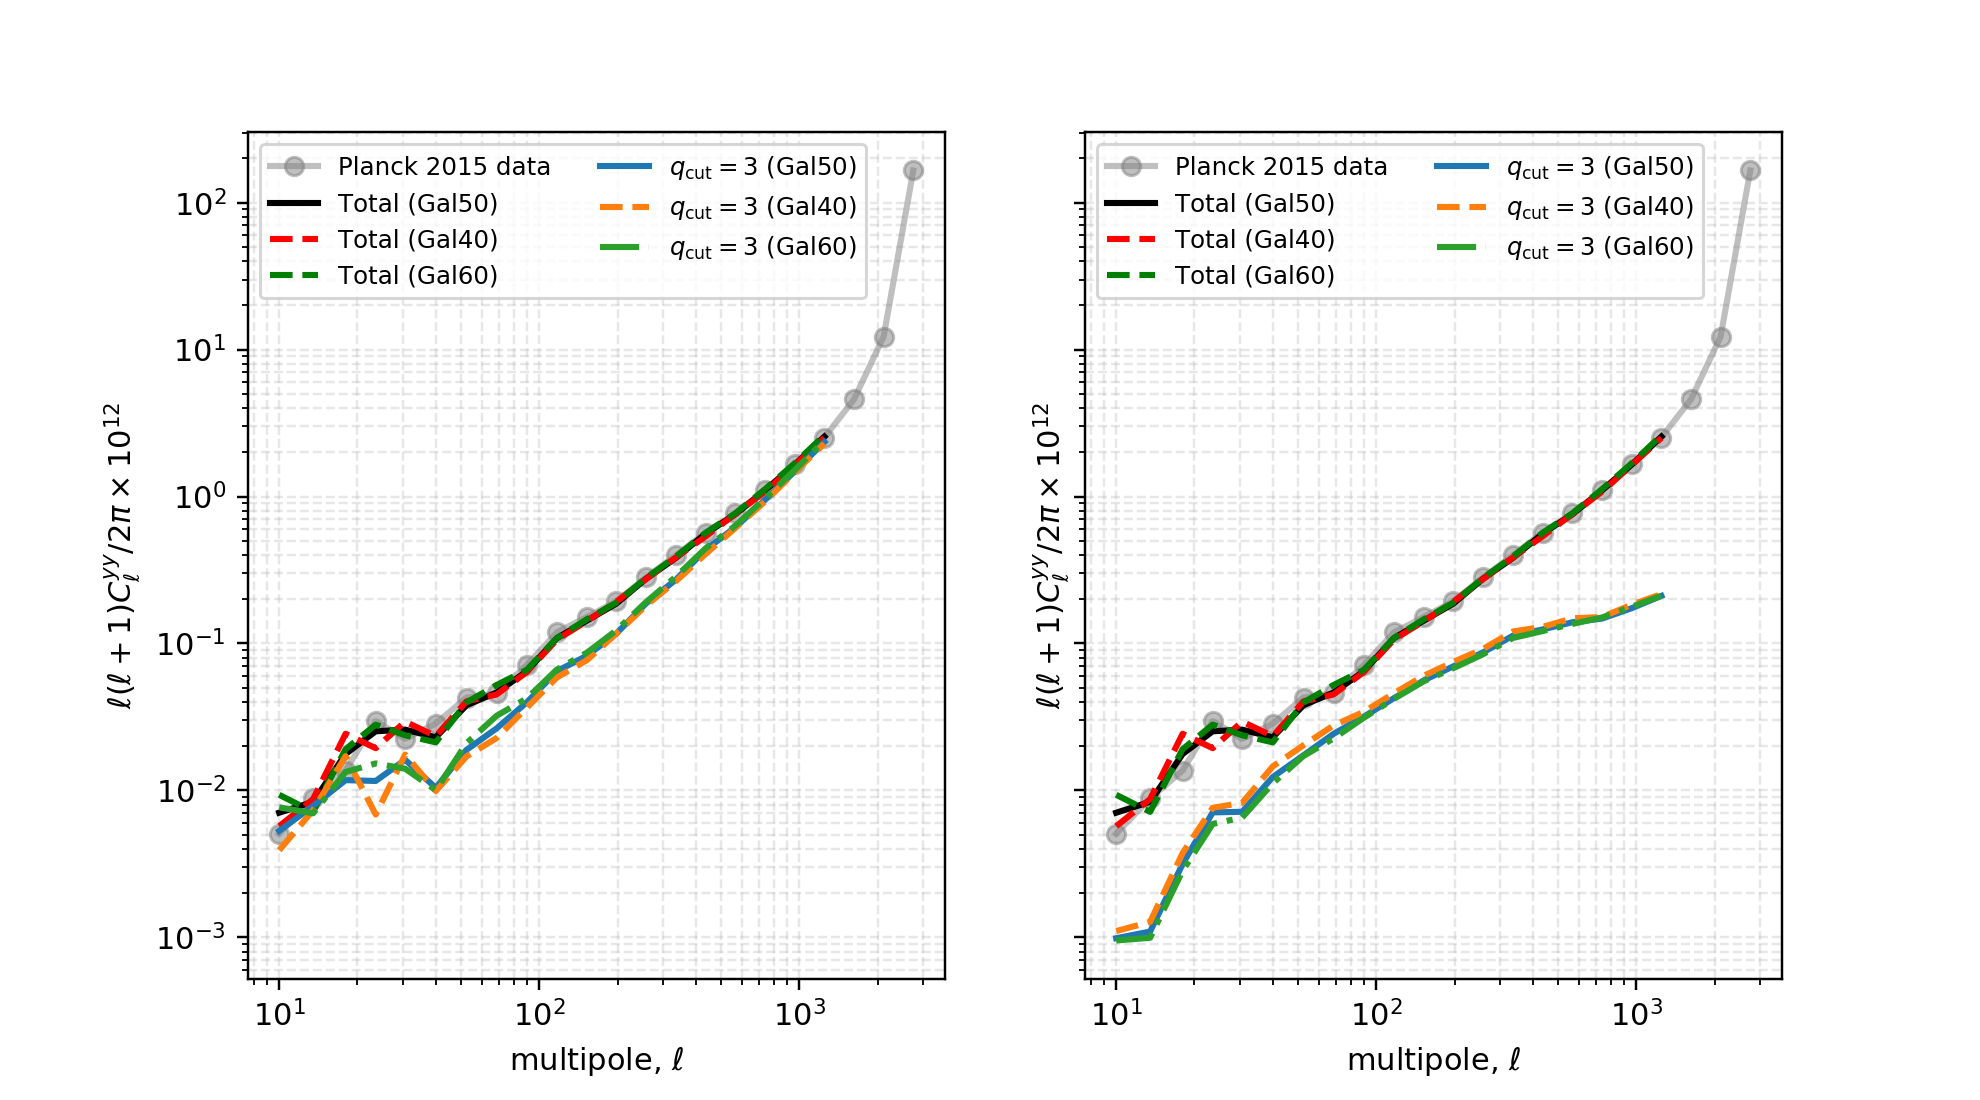

<IPython.core.display.Javascript object>


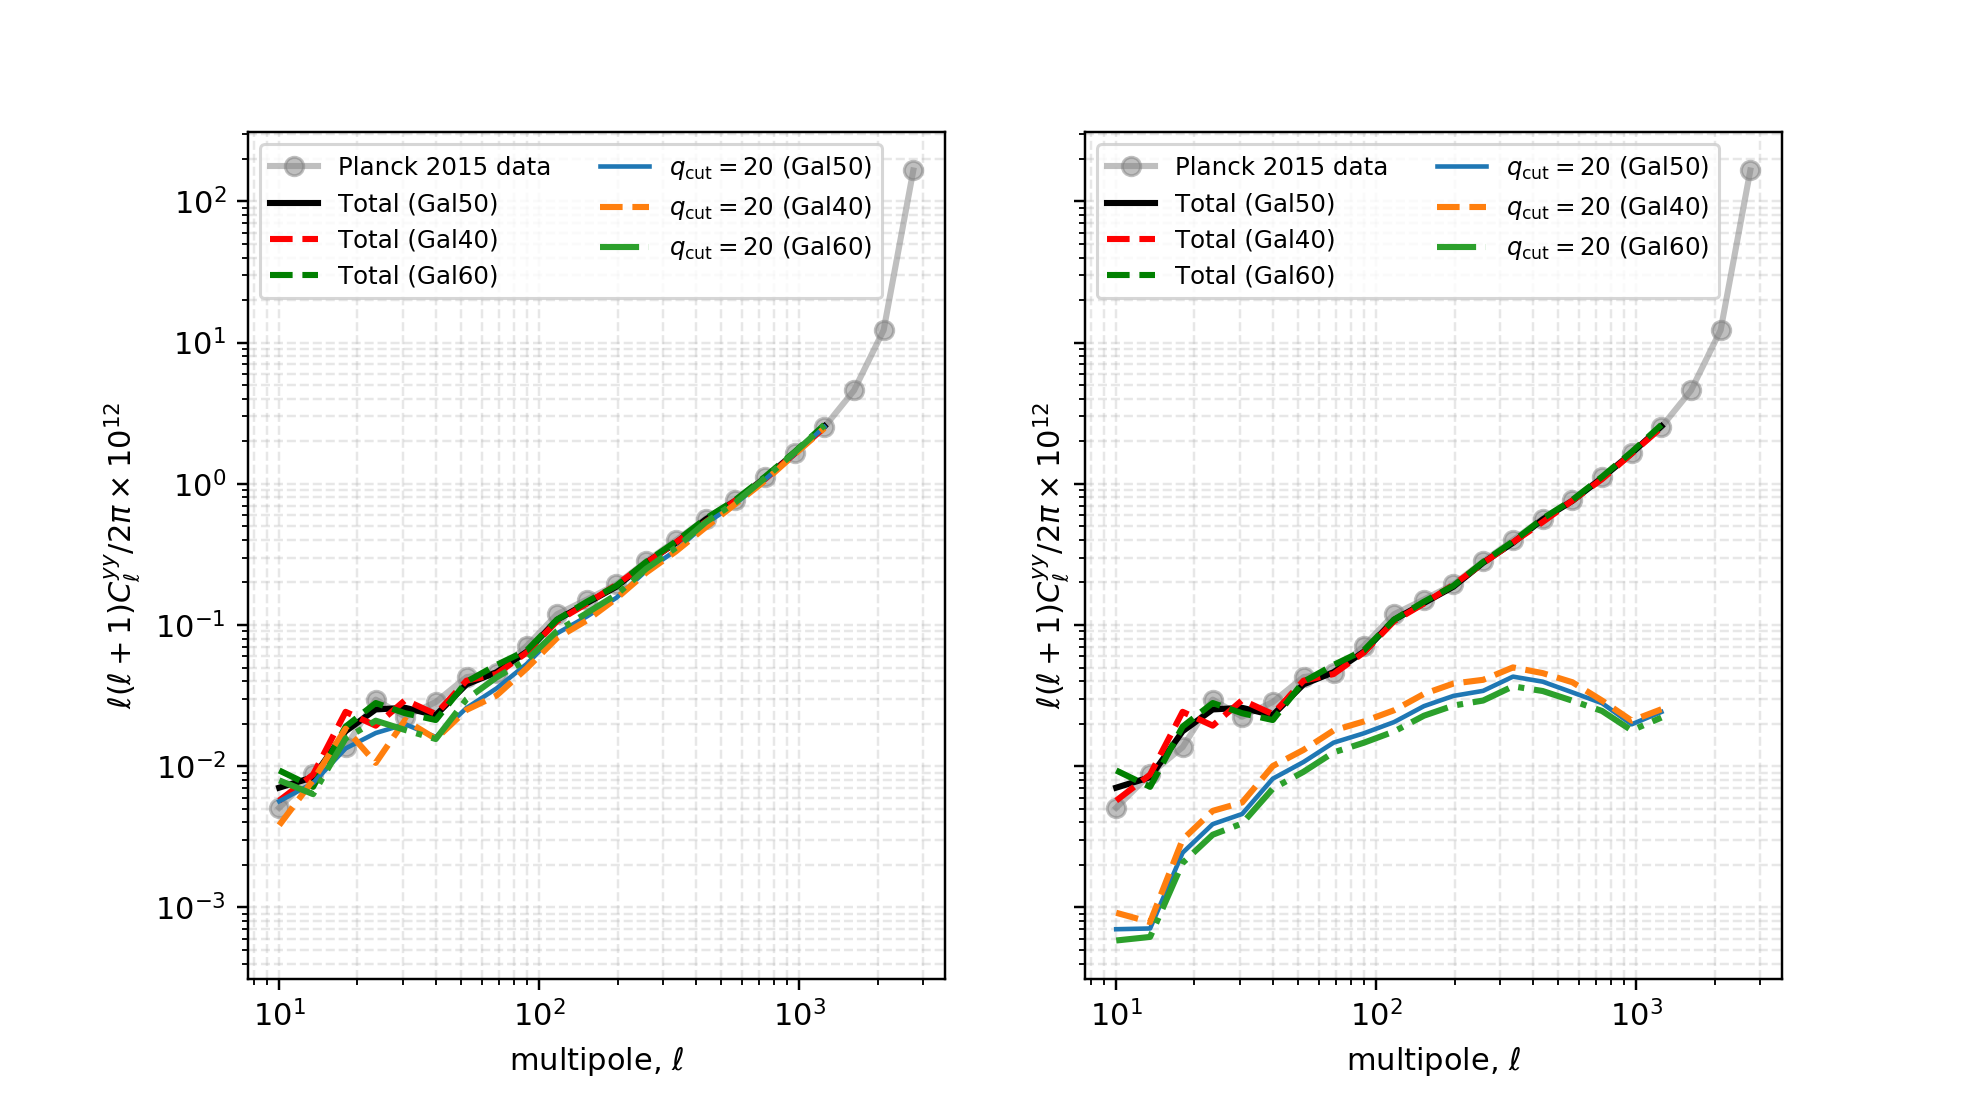

In [15]:
fig,ax=subplots(nrows=1,ncols=2,sharey=True,figsize=(9,5))
ax[0].plot(tot[:,2],tot[:,3],"k-",lw=2,label="Total")
ax[0].plot(urc3[:,2],urc3[:,3],lw=2,label=r"$q_{\rm cut}=3$")
ax[0].plot(urc6[:,2],urc6[:,3],label=r"$q_{\rm cut}=6$")
ax[0].plot(urc9[:,2],urc9[:,3],label=r"$q_{\rm cut}=9$")
ax[0].plot(urc12[:,2],urc12[:,3],label=r"$q_{\rm cut}=12$")
ax[0].plot(urc20[:,2],urc20[:,3],label=r"$q_{\rm cut}=20$")
ax[0].loglog()
ax[0].set_ylim(1e-3,1)
ax[0].grid(which="both",alpha=0.3,linestyle="dashed")
ax[0].set_xlabel("multipole, $\ell$")
ax[0].set_ylabel(r"$\ell(\ell+1) C_{\ell}^{yy}/2 \pi \times 10^{12}$")
ax[0].plot(data[:,0],data[:,1],lw=2,label="1 Halo")
ax[0].plot(data[:,0],data[:,6],lw=2,label="2 Halo")
ax[0].plot(data[:,0],data[:,6]+data[:,1],lw=2,label="1 Halo + 2 Halo")
ax[0].legend(loc=0)
ax[1].plot(tot[:,2],tot[:,3],"k-",lw=2,label="Total")
ax[1].plot(rc3[:,2],rc3[:,3],lw=2,label=r"$q_{\rm cut}=3$")
ax[1].plot(rc6[:,2],rc6[:,3],label=r"$q_{\rm cut}=6$")
ax[1].plot(rc9[:,2],rc9[:,3],label=r"$q_{\rm cut}=9$")
ax[1].plot(rc12[:,2],rc12[:,3],label=r"$q_{\rm cut}=12$")
ax[1].plot(rc20[:,2],rc20[:,3],label=r"$q_{\rm cut}=20$")
ax[1].loglog()
ax[1].grid(which="both",alpha=0.3,linestyle="dashed")
ax[1].legend(loc=0)
ax[1].set_xlabel("multipole, $\ell$")
ax[1].set_ylabel(r"$\ell(\ell+1) C_{\ell}^{yy}/2 \pi \times 10^{12}$")

figname="../../results/yy_spec/all_qcut_gal50.pdf"
savefig(figname, bbox_inches="tight",dpi=200)


fig,ax=subplots(nrows=1,ncols=2,sharey=True,figsize=(9,5))
# figure()
ax[0].plot(planck_yy[:,0],planck_yy[:,1],"-o",color="gray",lw=2,label="Planck 2015 data",alpha=0.5)
ax[0].plot(tot[:,2],tot[:,3],"k-",lw=2,label="Total (Gal50)")
# ax[0].plot(tot_g30[:,2],tot_g30[:,3],"--",c="b",lw=2,label="Total (Gal30)")
ax[0].plot(tot_g40[:,2],tot_g40[:,3],"--",c="r",lw=2,label="Total (Gal40)")
ax[0].plot(tot_g60[:,2],tot_g60[:,3],"--",c="g",lw=2,label="Total (Gal60)")
ax[0].plot(urc3[:,2],urc3[:,3],lw=2,label=r"$q_{\rm cut}=3$ (Gal50)")
ax[0].plot(urc3_g40[:,2],urc3_g40[:,3],"--",lw=2,label=r"$q_{\rm cut}=3$ (Gal40)")
ax[0].plot(urc3_g60[:,2],urc3_g60[:,3],"-.",lw=2,label=r"$q_{\rm cut}=3$ (Gal60)")
ax[0].loglog()
ax[0].grid(which="both",alpha=0.3,linestyle="dashed")
ax[0].legend(loc=0,ncol=2,fontsize=8)
# ax[0].set_xlim(2,200)
ax[0].set_xlabel("multipole, $\ell$")
ax[0].set_ylabel(r"$\ell(\ell+1) C_{\ell}^{yy}/2 \pi \times 10^{12}$")

ax[1].plot(planck_yy[:,0],planck_yy[:,1],"-o",color="gray",lw=2,label="Planck 2015 data",alpha=0.5)
ax[1].plot(tot[:,2],tot[:,3],"k-",lw=2,label="Total (Gal50)")
ax[1].plot(tot_g40[:,2],tot_g40[:,3],"--",c="r",lw=2,label="Total (Gal40)")
ax[1].plot(tot_g60[:,2],tot_g60[:,3],"--",c="g",lw=2,label="Total (Gal60)")
ax[1].plot(rc3[:,2],rc3[:,3],lw=2,label=r"$q_{\rm cut}=3$ (Gal50)")
ax[1].plot(rc3_g40[:,2],rc3_g40[:,3],"--",lw=2,label=r"$q_{\rm cut}=3$ (Gal40)")
ax[1].plot(rc3_g60[:,2],rc3_g60[:,3],"-.",lw=2,label=r"$q_{\rm cut}=3$ (Gal60)")
ax[1].loglog()
ax[1].grid(which="both",alpha=0.3,linestyle="dashed")
ax[1].legend(loc=0,ncol=2,fontsize=8)
# ax[1].set_xlim(2,200)
ax[1].set_xlabel("multipole, $\ell$")
ax[1].set_ylabel(r"$\ell(\ell+1) C_{\ell}^{yy}/2 \pi \times 10^{12}$")
figname="../../results/yy_spec/qcut3_variable_mask.pdf"
savefig(figname, bbox_inches="tight",dpi=200)

fig,ax=subplots(nrows=1,ncols=2,sharey=True,figsize=(9,5))
# figure()
ax[0].plot(planck_yy[:,0],planck_yy[:,1],"-o",color="gray",lw=2,label="Planck 2015 data",alpha=0.5)
ax[0].plot(tot[:,2],tot[:,3],"k-",lw=2,label="Total (Gal50)")
ax[0].plot(tot_g40[:,2],tot_g40[:,3],"--",c="r",lw=2,label="Total (Gal40)")
ax[0].plot(tot_g60[:,2],tot_g60[:,3],"--",c="g",lw=2,label="Total (Gal60)")
ax[0].plot(urc20[:,2],urc20[:,3],label=r"$q_{\rm cut}=20$ (Gal50)")
ax[0].plot(urc20_g40[:,2],urc20_g40[:,3],"--",lw=2,label=r"$q_{\rm cut}=20$ (Gal40)")
ax[0].plot(urc20_g60[:,2],urc20_g60[:,3],"-.",lw=2,label=r"$q_{\rm cut}=20$ (Gal60)")
ax[0].loglog()
ax[0].grid(which="both",alpha=0.3,linestyle="dashed")
ax[0].legend(loc=0,ncol=2,fontsize=8)
ax[0].set_xlabel("multipole, $\ell$")
ax[0].set_ylabel(r"$\ell(\ell+1) C_{\ell}^{yy}/2 \pi \times 10^{12}$")

ax[1].plot(planck_yy[:,0],planck_yy[:,1],"-o",color="gray",lw=2,label="Planck 2015 data",alpha=0.5)
ax[1].plot(tot[:,2],tot[:,3],"k-",lw=2,label="Total (Gal50)")
ax[1].plot(tot_g40[:,2],tot_g40[:,3],"--",c="r",lw=2,label="Total (Gal40)")
ax[1].plot(tot_g60[:,2],tot_g60[:,3],"--",c="g",lw=2,label="Total (Gal60)")
ax[1].plot(rc20[:,2],rc20[:,3],label=r"$q_{\rm cut}=20$ (Gal50)")
ax[1].plot(rc20_g40[:,2],rc20_g40[:,3],'--',lw=2,label=r"$q_{\rm cut}=20$ (Gal40)")
ax[1].plot(rc20_g60[:,2],rc20_g60[:,3],'-.',lw=2,label=r"$q_{\rm cut}=20$ (Gal60)")
ax[1].loglog()
ax[1].grid(which="both",alpha=0.3,linestyle="dashed")
ax[1].legend(loc=0,ncol=2,fontsize=8)
# ax[1].set_xlim(2,200)
ax[1].set_xlabel("multipole, $\ell$")
ax[1].set_ylabel(r"$\ell(\ell+1) C_{\ell}^{yy}/2 \pi \times 10^{12}$")
figname="../../results/yy_spec/qcut20_variable_mask.pdf"
savefig(figname, bbox_inches="tight",dpi=200)

# Fsky table

In [28]:
fskytable=collections.OrderedDict()
fskytable[r"$q_{\rm cut}$"]=[3,6,9,12,20]
fskytable["uRC (\%)"]=np.array([0.343575, 0.344612, 0.349003, 0.350654, 0.352572])*100
fskytable["RC (\%)"]=np.array([0.012225, 0.011039,0.005965, 0.004092, 0.001958 ])*100

fskypd=pd.DataFrame(fskytable)

In [33]:
fskypd.to_latex("../../results/yy_spec/fsky.tex",column_format="ccc",multirow=True,index=False,escape=False,float_format="%.2f")

# Dependence on radius of cluster mask

In [21]:
tot5=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/total_yy_spec.txt")
rc5=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/resolved_yy_spec.txt")
urc5=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_psmask/data/unresolved_yy_spec.txt")

tot3=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_3theta_psmask/data/total_yy_spec.txt")
rc3=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_3theta_psmask/data/resolved_yy_spec.txt")
urc3=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_3theta_psmask/data/unresolved_yy_spec.txt")

tot10=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_10theta_psmask/data/total_yy_spec.txt")
rc10=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_10theta_psmask/data/resolved_yy_spec.txt")
urc10=loadtxt("../../results/yy_spec/snr6_lmax1500_mlmax4096_apow15_10theta_psmask/data/unresolved_yy_spec.txt")

<IPython.core.display.Javascript object>


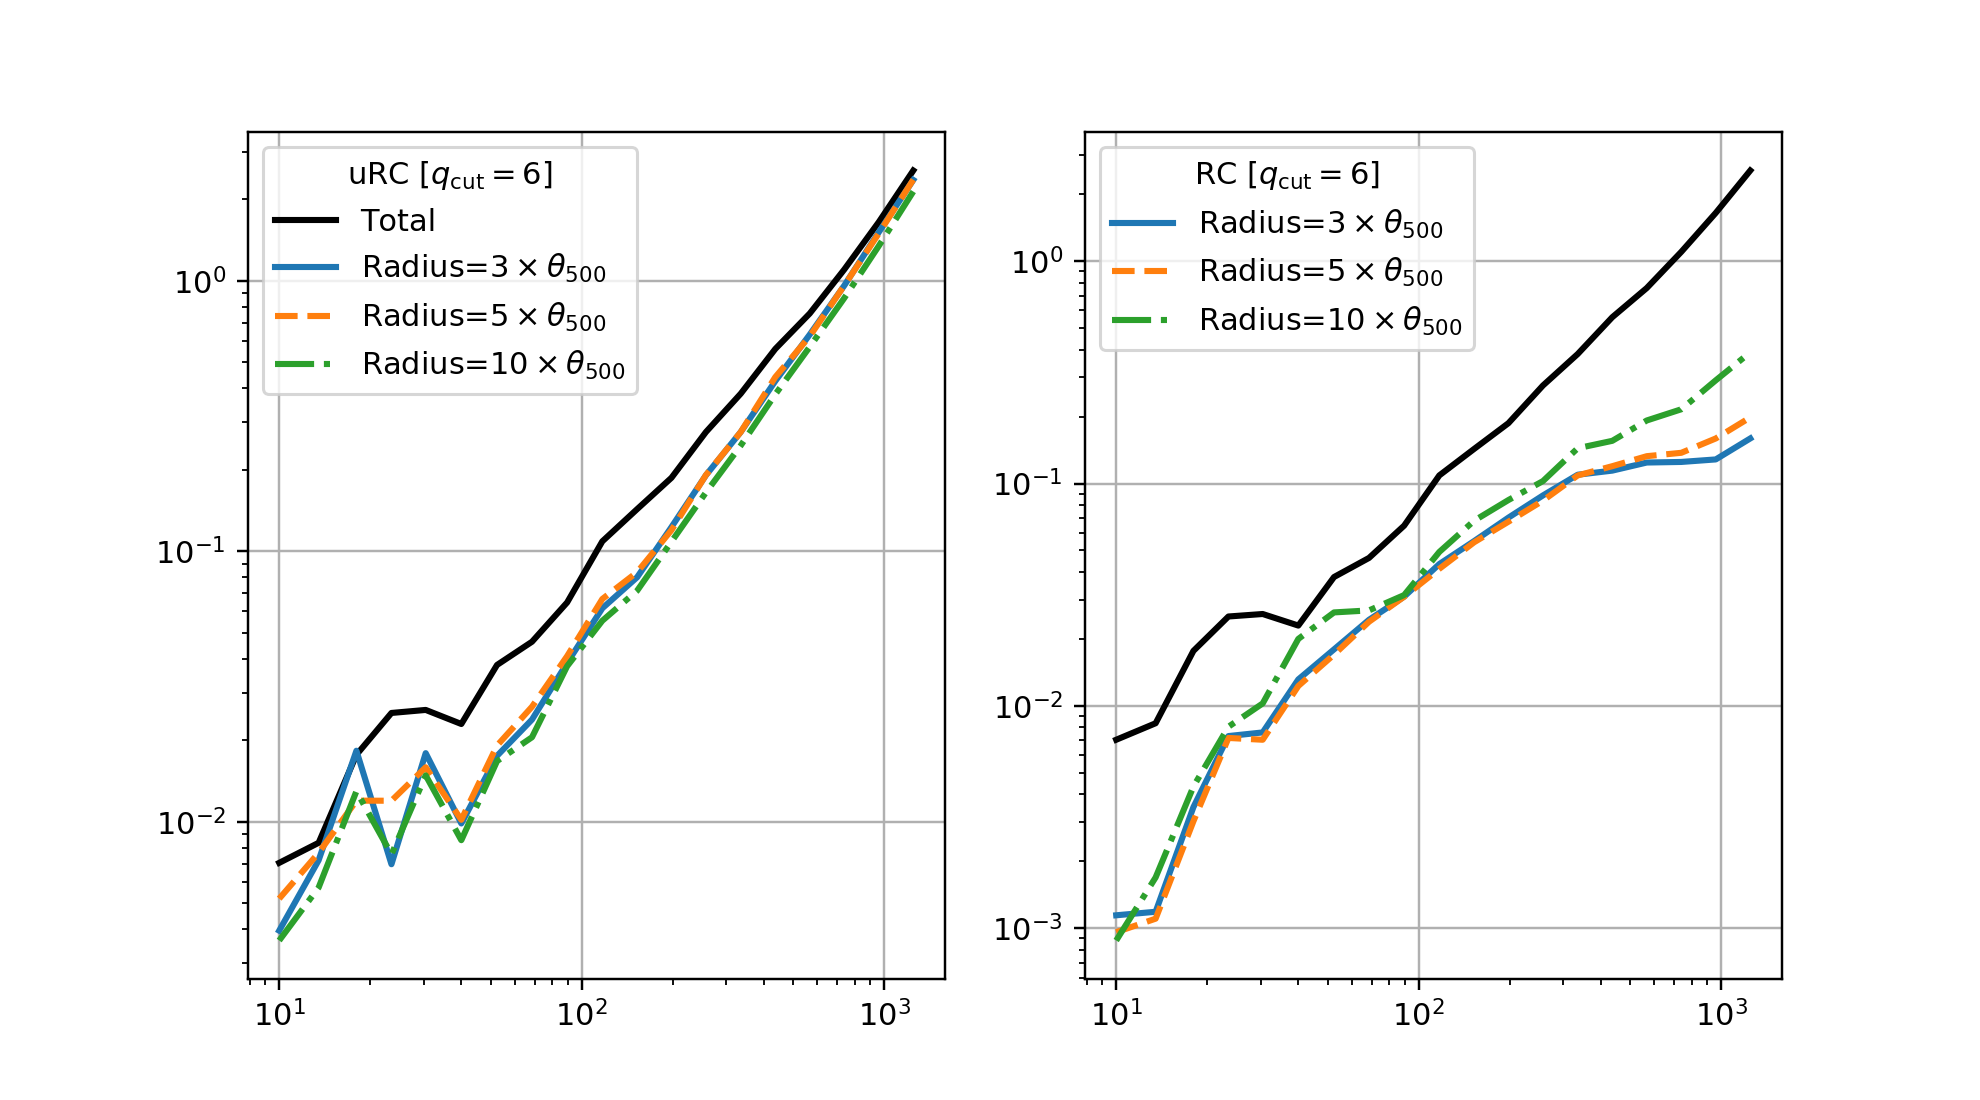

In [30]:
fig, ax=subplots(nrows=1,ncols=2,figsize=(9,5))
ax[0].plot(tot5[:,2],tot5[:,3],"k-",lw=2,label="Total")
ax[0].plot(urc3[:,2],urc3[:,3],"-",lw=2,label=r"Radius=$3\times \theta_{500}$")
ax[0].plot(urc5[:,2],urc5[:,3],"--",lw=2,label=r"Radius=$5\times \theta_{500}$")
ax[0].plot(urc10[:,2],urc10[:,3],"-.",lw=2,label=r"Radius=$10\times \theta_{500}$")
ax[0].grid()
ax[0].loglog()
ax[0].legend(loc=0,title=r"uRC [$q_{\rm cut}=6$]")

ax[1].plot(tot5[:,2],tot5[:,3],"k-",lw=2)
ax[1].plot(rc3[:,2],rc3[:,3],"-",lw=2,label=r"Radius=$3\times \theta_{500}$")
ax[1].plot(rc5[:,2],rc5[:,3],"--",lw=2,label=r"Radius=$5\times \theta_{500}$")
ax[1].plot(rc10[:,2],rc10[:,3],"-.",lw=2,label=r"Radius=$10\times \theta_{500}$")
ax[1].grid()
ax[1].loglog()
ax[1].legend(loc=0,title=r"RC [$q_{\rm cut}=6$]")

figname="../../results/yy_spec/cluster_mask_size_dependence.pdf"
savefig(figname, bbox_inches="tight",dpi=200)

In [11]:
(3./8.)*439

164.625

In [12]:
0.35/0.45


0.7777777777777777